In [8]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import argparse
import torch.nn as nn
import random
import cv2
import matplotlib.pyplot as plt

from tqdm import trange
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

from dataset_utility import dataset, pgm_tsne, ToTensor
from model.RANet_tsne import RANet

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [9]:
args = argparse.Namespace(
    model_name = 'RANet',
    batch_size = 32,
    root = '../dataset',
    dataset = 'PGM',
    fig_type = 'neutral',
    img_size = 160,
    workers = 4,
    save = './results/checkpoint/',
    train_mode = 0,
    train_once = False,
    seed = 12345,
)

In [10]:
if args.fig_type == 'all':
    args.train_once = True
else:
    args.train_once = False

if args.dataset == 'PGM':
    args.train_once = False

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
# torch.manual_seed(args.seed)
# if torch.cuda.is_available:
#     torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
# random.seed(args.seed)

device: cuda


In [12]:
model = RANet()
model.to(device)

RANet(
  (scattering): Scattering()
  (conv): CNNModule(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [13]:
save_name = args.model_name + '_' + args.dataset + '_' + args.fig_type

save_path_model = os.path.join(args.save, save_name)

tf = transforms.Compose([ToTensor()])

In [14]:
test_set = pgm_tsne(os.path.join(args.root, args.dataset), 'test', args.fig_type, args.img_size, tf, args.train_once)

print('test length', len(test_set), args.fig_type)

test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True)

test length 200000 neutral


In [15]:
def visualize():
    model.eval()
    all_inter = []
    all_gts = []
    
    data_i = []
    for i in range(10000):
        number = random.randint(0,200000)
        image, target, meta_target, structure_encoded = test_set[i]

        if torch.equal(meta_target, structure_encoded[0]):
            data_i.append(i)
        else:
            continue

    for i in data_i:
        image, target, meta_target, structure_encoded = test_set[i]
        
        image = image.to(device).unsqueeze(0)
        target = target
        
        with torch.no_grad():
            predict, att_maps, rel_vector = model(image)
            predict = F.softmax(predict)
            
        if predict[:,target] > 0.4:
            rel_vector = rel_vector.cpu().numpy()
            meta_target = meta_target[7:12]
            all_inter.append(rel_vector)
            all_gts.append(meta_target)
    return all_inter, all_gts

C:\Users\SeungGyu\AppData\Local\Temp\ipykernel_37312\200542926.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = F.softmax(predict)


(3682, 160)


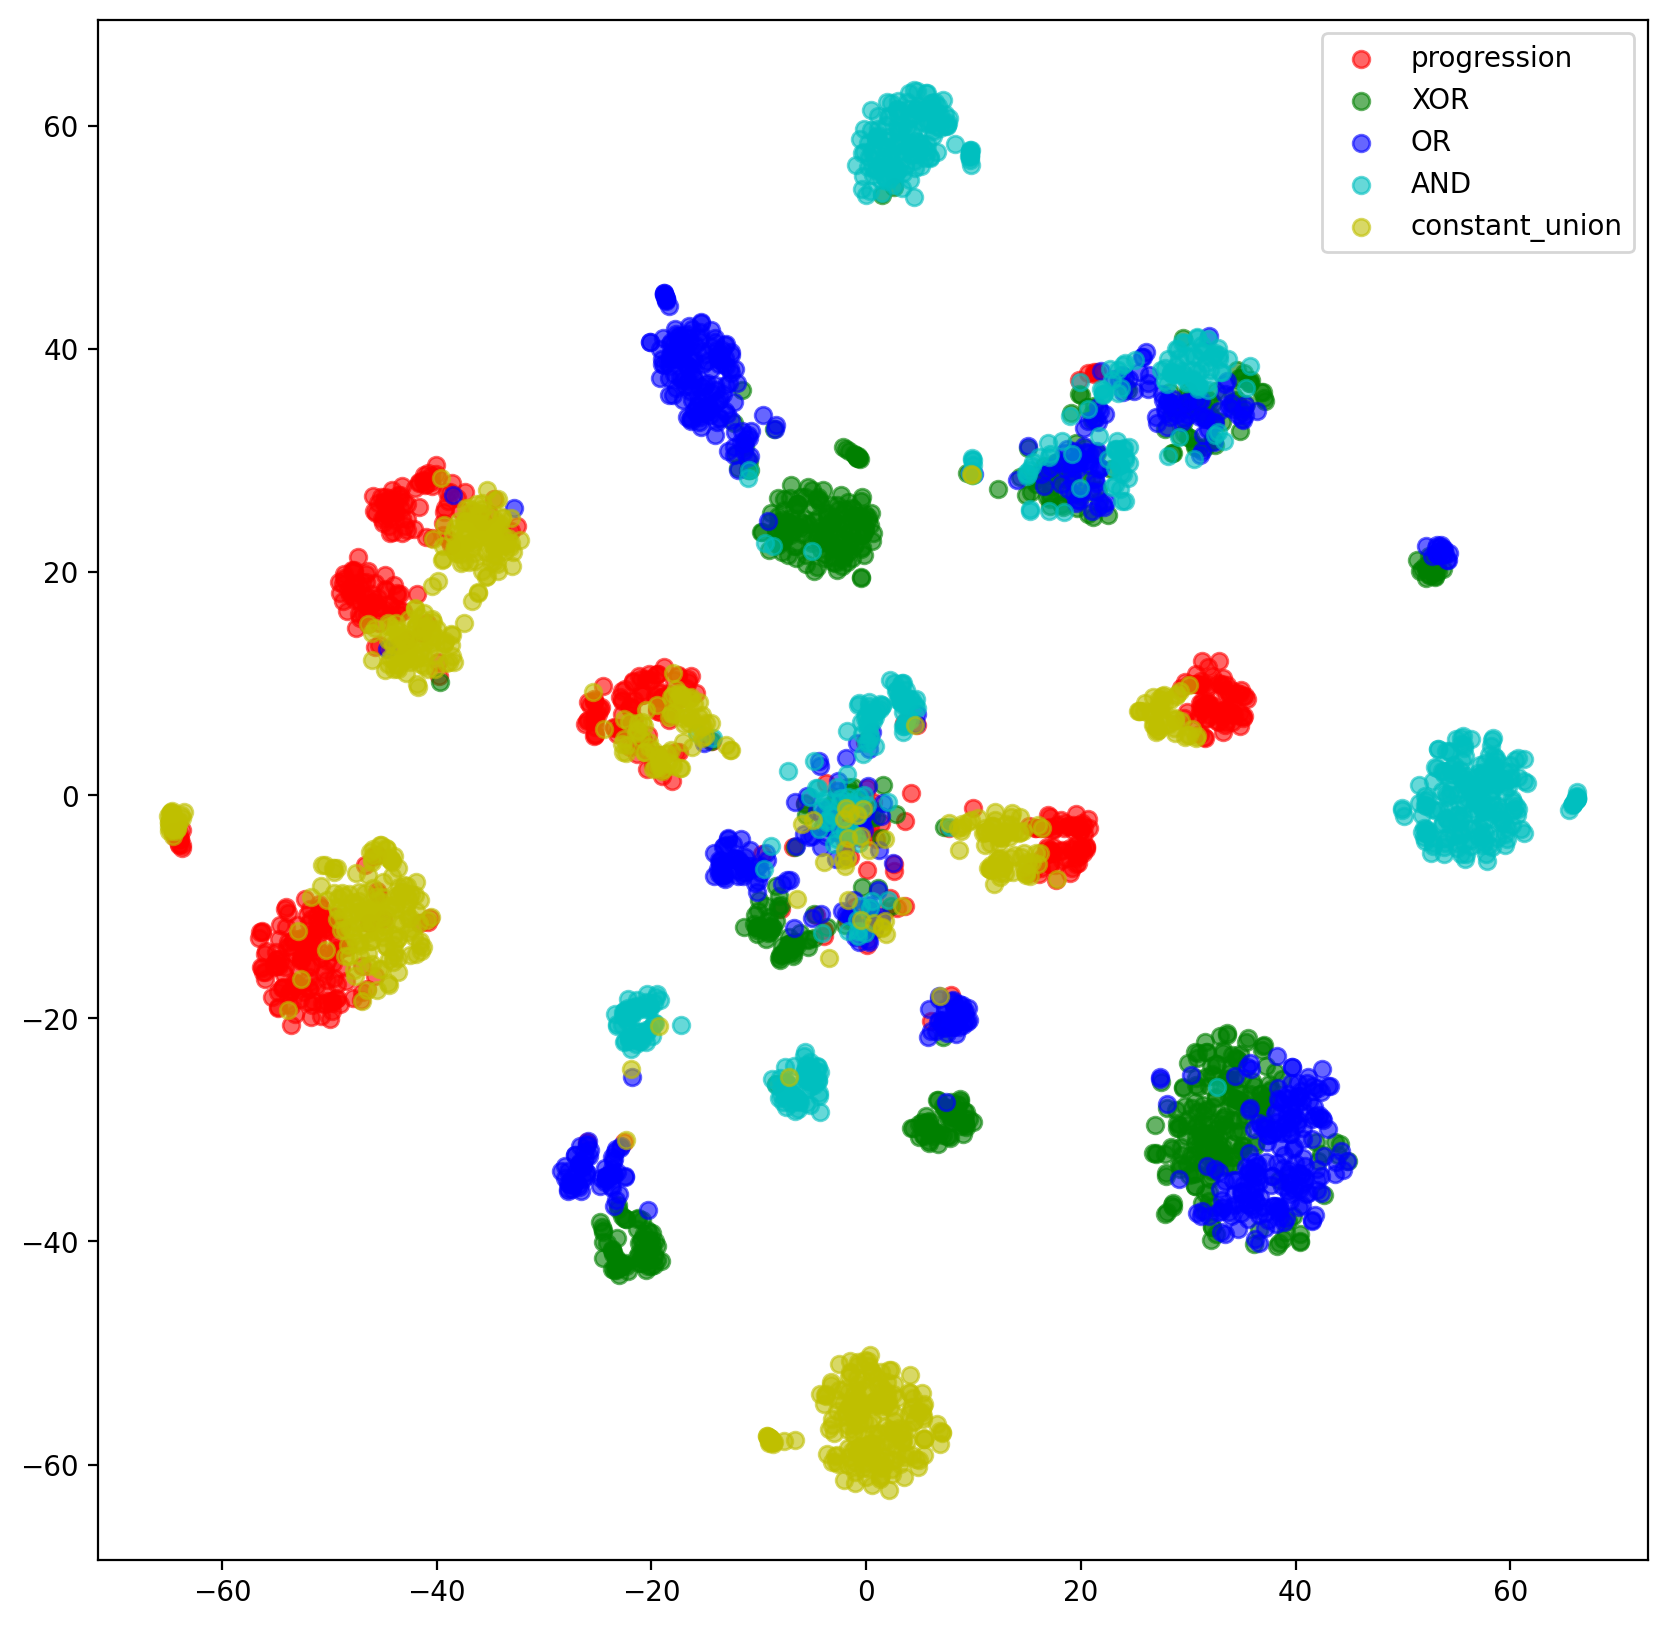

In [16]:
if __name__ == '__main__':
    model.load_state_dict(torch.load('./model.pth'))

    inter_vector, gts = visualize()
    inter_vector = np.array(inter_vector)
    print(inter_vector.shape)

    tsne = TSNE(n_components=2, perplexity=30.0)
    inter_vector_2d = tsne.fit_transform(inter_vector)

    labels = ['progression', 'XOR', 'OR', 'AND', 'constant_union']
    colors = ['r', 'g', 'b', 'c', 'y']

    plt.figure(figsize=(10,10), dpi=200)
    for i in range(5):
        indices = [j for j, x in enumerate(gts) if torch.argmax(x) == i]
        plt.scatter(inter_vector_2d[indices, 0], inter_vector_2d[indices, 1], c=colors[i], label=labels[i], alpha=0.6)
    plt.legend()
    plt.show()